In [ ]:
!pip install kaggle --quiet

import os
from getpass import getpass
import pandas as pd
import numpy as np
import re, string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt

In [ ]:
os.environ['KAGGLE_USERNAME'] = input("Kaggle Username: ")
os.environ['KAGGLE_KEY']      = getpass("Kaggle Key: ")

Kaggle Username: jobjonathan
Kaggle Key: ··········


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d madhab/jobposts
!unzip jobposts.zip

Dataset URL: https://www.kaggle.com/datasets/madhab/jobposts
License(s): CC0-1.0
  0% 0.00/14.0M [00:00<?, ?B/s]
100% 14.0M/14.0M [00:00<00:00, 784MB/s]
Archive:  jobposts.zip
  inflating: data job posts.csv      
  inflating: screenshot.jpg          


In [ ]:
df = pd.read_csv('/content/data job posts.csv')
df.head()


,jobpost,date,Title,Company,AnnouncementCode,Term,Eligibility,Audience,StartDate,Duration,...,Salary,ApplicationP,OpeningDate,Deadline,Notes,AboutC,Attach,Year,Month,IT
0,AMERIA Investment Consulting Company\r\nJOB TI...,"Jan 5, 2004",Chief Financial Officer,AMERIA Investment Consulting Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"To apply for this position, please submit a\r\...",NaN,26 January 2004,NaN,NaN,NaN,2004,1,False
1,International Research & Exchanges Board (IREX...,"Jan 7, 2004",Full-time Community Connections Intern (paid i...,International Research & Exchanges Board (IREX),NaN,NaN,NaN,NaN,NaN,3 months,...,NaN,Please submit a cover letter and resume to:\r\...,NaN,12 January 2004,NaN,The International Research & Exchanges Board (...,NaN,2004,1,False
2,Caucasus Environmental NGO Network (CENN)\r\nJ...,"Jan 7, 2004",Country Coordinator,Caucasus Environmental NGO Network (CENN),NaN,NaN,NaN,NaN,NaN,Renewable annual contract\r\nPOSITION,...,NaN,Please send resume or CV toursula.kazarian@......,NaN,20 January 2004\r\nSTART DATE: February 2004,NaN,The Caucasus Environmental NGO Network is a\r\...,NaN,2004,1,False
3,Manoff Group\r\nJOB TITLE: BCC Specialist\r\n...,"Jan 7, 2004",BCC Specialist,Manoff Group,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Please send cover letter and resume to Amy\r\n...,NaN,23 January 2004\r\nSTART DATE: Immediate,NaN,NaN,NaN,2004,1,False
4,Yerevan Brandy Company\r\nJOB TITLE: Software...,"Jan 10, 2004",Software Developer,Yerevan Brandy Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Successful candidates should submit\r\n- CV; \...,NaN,"20 January 2004, 18:00",NaN,NaN,NaN,2004,1,True


In [ ]:
# Drop rows where the core text fields are missing
df = df.dropna(subset=['JobDescription', 'Title']).reset_index(drop=True)

# Install and import NLTK resources
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re, string

stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

def clean_text(text):
    """Lowercase, strip HTML, remove punctuation & numbers, stem, drop stopwords."""
    text = str(text).lower()
    text = re.sub(r'<.*?>', '', text)                           # strip HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)  # drop punctuation
    text = re.sub(r'\d+', '', text)                             # drop digits
    tokens = text.split()
    tokens = [stemmer.stem(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)

# Apply to the JobDescription column
df['cleaned_description'] = df['JobDescription'].apply(clean_text)

# Quick peek at the result
df[['JobDescription','cleaned_description']].head()


,JobDescription,cleaned_description
0,AMERIA Investment Consulting Company is seekin...,ameria invest consult compani seek chief finan...
1,Public outreach and strengthening of a growing...,public outreach strengthen grow network enviro...
2,The LEAD (Local Enhancement and Development fo...,lead local enhanc develop health bcc specialis...
3,Saleswoman will sell menswear and accessories.,saleswoman sell menswear accessori
4,The Armenian Branch Office of the Open Society...,armenian branch offic open societi institut as...


In [ ]:
# Cell X+1: Create & encode target categories, then split data

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# 1) Define a simple rule-based category from the job Title
def assign_category(title):
    t = title.lower()
    if any(k in t for k in ['developer', 'software', 'engineer', 'it', 'programmer']):
        return 'IT'
    elif any(k in t for k in ['marketing', 'brand', 'sales', 'advert']):
        return 'Marketing'
    elif any(k in t for k in ['nurse', 'health', 'medical', 'doctor', 'clinic']):
        return 'Healthcare'
    else:
        return 'Other'

df['category'] = df['Title'].apply(assign_category)

# 2) (Optional) Drop the 'Other' bucket if you want a clean 3-class problem
df = df[df['category'] != 'Other'].reset_index(drop=True)

# 3) Encode labels
le = LabelEncoder()
df['cat_enc'] = le.fit_transform(df['category'])

# 4) Train/test split
X = df['cleaned_description']
y = df['cat_enc']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Classes:", le.classes_)
print("Training samples per class:\n", pd.Series(y_train).map(lambda x: le.inverse_transform([x])[0]).value_counts())


Classes: ['Healthcare' 'IT' 'Marketing']
Training samples per class:
 cat_enc
IT            4084
Marketing      890
Healthcare     293
Name: count, dtype: int64


In [ ]:
# Cell X+2: TF–IDF Vectorization of Cleaned Descriptions

from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize vectorizer (you can tweak max_features as needed)
vectorizer = TfidfVectorizer(max_features=5000)

# Fit on training data and transform both train & test
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec  = vectorizer.transform(X_test)

print(f"Vectorized shapes → X_train: {X_train_vec.shape}, X_test: {X_test_vec.shape}")


Vectorized shapes → X_train: (5267, 4566), X_test: (1317, 4566)


In [ ]:
  from sklearn.naive_bayes import MultinomialNB
  from sklearn.metrics import classification_report

  # Initialize and train
  nb_model = MultinomialNB()
  nb_model.fit(X_train_vec, y_train)

  # Predict & report
  nb_preds = nb_model.predict(X_test_vec)
  print("Naive Bayes Classification Report:\n")
  print(classification_report(y_test, nb_preds, target_names=le.classes_))


Naive Bayes Classification Report:

              precision    recall  f1-score   support

  Healthcare       0.95      0.53      0.68        73
          IT       0.91      0.99      0.95      1021
   Marketing       0.94      0.70      0.80       223

    accuracy                           0.92      1317
   macro avg       0.93      0.74      0.81      1317
weighted avg       0.92      0.92      0.91      1317



In [ ]:
# Cell X+4: Train & Evaluate Support Vector Machine Classifier

from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

# Initialize and train
svm_model = LinearSVC(max_iter=10000)
svm_model.fit(X_train_vec, y_train)

# Predict & report
svm_preds = svm_model.predict(X_test_vec)
print("Support Vector Machine Classification Report:\n")
print(classification_report(y_test, svm_preds, target_names=le.classes_))


Support Vector Machine Classification Report:

              precision    recall  f1-score   support

  Healthcare       0.93      0.88      0.90        73
          IT       0.98      0.99      0.98      1021
   Marketing       0.95      0.93      0.94       223

    accuracy                           0.97      1317
   macro avg       0.95      0.93      0.94      1317
weighted avg       0.97      0.97      0.97      1317



In [ ]:
# Cell X+6: Fixing KeyError — Use the correct 'date' column name

# 1) Verify column names (optional)
print("Columns available:", df.columns.tolist())

# 2) Select using 'date' (lowercase) instead of 'Date'
recommended = df.iloc[top_indices][['Title', 'Company', 'category', 'date', 'JobDescription']]

# 3) Reset index and display
recommended.reset_index(drop=True)


Columns available: ['jobpost', 'date', 'Title', 'Company', 'AnnouncementCode', 'Term', 'Eligibility', 'Audience', 'StartDate', 'Duration', 'Location', 'JobDescription', 'JobRequirment', 'RequiredQual', 'Salary', 'ApplicationP', 'OpeningDate', 'Deadline', 'Notes', 'AboutC', 'Attach', 'Year', 'Month', 'IT', 'cleaned_description', 'category', 'cat_enc']


,Title,Company,category,date,JobDescription
0,Senior Node.js Developer,"Bazillion Beings, Inc.",IT,"Jul 17, 2015",The incumbent will design and develop a full s...
1,Python Developers,Broncoway LLC,IT,"Mar 27, 2005",We are looking for experienced Python Develope...
2,Senior Software Engineer (Crystal Reports/ SQL),"LinkGard Systems, LLC",IT,"Jul 25, 2006","LinkGard Systems, LLC is seeking highly experi..."
3,Software Developer in Test,VMware Armenia LLC,IT,"Mar 27, 2014",VMware Armenia is looking for a Software Devel...
4,Software Developer in Test,VMware Armenia LLC,IT,"Oct 25, 2013",VMware Armenia is looking for a Software Devel...


In [ ]:
# Cell X+7: Compute Overall Evaluation Metrics for Both Models

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Naive Bayes metrics
nb_acc   = accuracy_score(y_test, nb_preds)
nb_prec  = precision_score(y_test, nb_preds, average='weighted')
nb_rec   = recall_score(y_test, nb_preds, average='weighted')
nb_f1    = f1_score(y_test, nb_preds, average='weighted')

# SVM metrics
svm_acc  = accuracy_score(y_test, svm_preds)
svm_prec = precision_score(y_test, svm_preds, average='weighted')
svm_rec  = recall_score(y_test, svm_preds, average='weighted')
svm_f1   = f1_score(y_test, svm_preds, average='weighted')

print("Naive Bayes Performance:")
print(f"  Accuracy:  {nb_acc:.3f}")
print(f"  Precision: {nb_prec:.3f}")
print(f"  Recall:    {nb_rec:.3f}")
print(f"  F1-score:  {nb_f1:.3f}\n")

print("SVM Performance:")
print(f"  Accuracy:  {svm_acc:.3f}")
print(f"  Precision: {svm_prec:.3f}")
print(f"  Recall:    {svm_rec:.3f}")
print(f"  F1-score:  {svm_f1:.3f}")


Naive Bayes Performance:
  Accuracy:  0.916
  Precision: 0.919
  Recall:    0.916
  F1-score:  0.910

SVM Performance:
  Accuracy:  0.971
  Precision: 0.971
  Recall:    0.971
  F1-score:  0.971


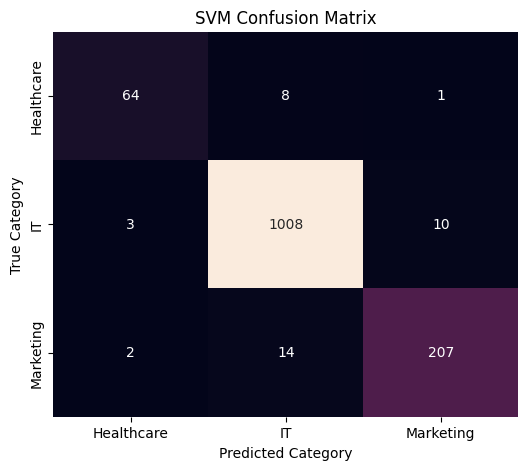

In [ ]:
# Cell X+8: Visualize the SVM Confusion Matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test, svm_preds)

# Plot as a heatmap
plt.figure(figsize=(6,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=le.classes_,
    yticklabels=le.classes_,
    cbar=False
)
plt.xlabel('Predicted Category')
plt.ylabel('True Category')
plt.title('SVM Confusion Matrix')
plt.show()


In [ ]:
# Cell X+9: Save Trained Models and Vectorizer for Later Use

import joblib

# Define filenames
NB_MODEL_FILE  = 'naive_bayes_model.joblib'
SVM_MODEL_FILE = 'svm_model.joblib'
VECTORIZER_FILE = 'tfidf_vectorizer.joblib'

# Save to disk
joblib.dump(nb_model, NB_MODEL_FILE)
joblib.dump(svm_model, SVM_MODEL_FILE)
joblib.dump(vectorizer, VECTORIZER_FILE)

print(f"Saved Naive Bayes model to {NB_MODEL_FILE}")
print(f"Saved SVM model to {SVM_MODEL_FILE}")
print(f"Saved TF-IDF vectorizer to {VECTORIZER_FILE}")


Saved Naive Bayes model to naive_bayes_model.joblib
Saved SVM model to svm_model.joblib
Saved TF-IDF vectorizer to tfidf_vectorizer.joblib


In [ ]:
# Cell X+10: Load Saved Models & Vectorizer, Define Inference Function

import joblib

# 1) Load the artifacts
nb_model      = joblib.load('naive_bayes_model.joblib')
svm_model     = joblib.load('svm_model.joblib')
tfidf_vectorizer = joblib.load('tfidf_vectorizer.joblib')

# 2) Inference helper
def predict_job_category(text, model='svm'):
    """
    Clean, vectorize, and predict the category for a new job description.
    model: 'svm' or 'nb'
    """
    # Clean
    cleaned = clean_text(text)
    # Vectorize
    vec = tfidf_vectorizer.transform([cleaned])
    # Choose model
    mdl = svm_model if model=='svm' else nb_model
    # Predict & decode label
    pred_enc = mdl.predict(vec)[0]
    return le.inverse_transform([pred_enc])[0]

# 3) Test on new samples
samples = [
    "We are seeking a Software Engineer to develop backend APIs in Python and Node.js.",
    "Looking for a Digital Marketing Specialist to manage social media campaigns and SEO."
]

for s in samples:
    print("Description:", s)
    print(" → NB prediction:", predict_job_category(s, model='nb'))
    print(" → SVM prediction:", predict_job_category(s, model='svm'))
    print()


Description: We are seeking a Software Engineer to develop backend APIs in Python and Node.js.
 → NB prediction: IT
 → SVM prediction: IT

Description: Looking for a Digital Marketing Specialist to manage social media campaigns and SEO.
 → NB prediction: IT
 → SVM prediction: IT

